<a href="https://colab.research.google.com/github/AnDDoanf/CNN-transfer-learning-dog-breed-classification/blob/master/CNN-transfer-learning-dog-breed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Kaggle"
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [2]:
# %rm -rf dog-data

In [3]:
# !kaggle competitions download -c dog-breed-identification
# !unzip *.zip -d dog-data

Streaming output truncated to the last 5000 lines.
  inflating: dog-data/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog-data/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog-data/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog-data/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog-data/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog-data/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog-data/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog-data/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog-data/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog-data/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog-data/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog-data/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog-data/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog-data/train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,Input,Dropout,MaxPooling2D
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB4, Xception, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import random
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('dog-data/labels.csv')
check_dir = os.listdir('./dog-data/train')

df.shape, len(check_dir)

((10222, 2), 10222)

In [6]:
class_names = df['breed'].unique()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [8]:
def read_and_resize_image_rgb(file_path):
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb_resized = cv2.resize(img_rgb, (224, 224))
    return img_rgb_resized


In [9]:
image_dir = 'dog-data/train'
cur_dir = os.getcwd()
resized_images = []
for idx, filename in enumerate(df['id']):
    img_path = os.path.join(cur_dir, image_dir, filename + '.jpg')
    resized_img = read_and_resize_image_rgb(img_path)
    resized_images.append(resized_img)
resized_images_array = np.array(resized_images)

In [10]:
resized_images_array.shape

(10222, 224, 224, 3)

In [11]:
# plt.figure(figsize=(10, 10))
# for i in range(20):
#     plt.subplot(4, 5, i + 1)
#     plt.imshow(resized_images_array[i])
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

## Transfer learning

In [12]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(df['breed'])
new_labels = to_categorical(label_encoded)

In [13]:
X = resized_images_array
y = new_labels

In [14]:
def get_features(model_name, model_preprocessor, input_size, data):
    input_layer = Input(input_size)
    preprocessor = model_preprocessor(input_layer)
    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)

    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=avg)
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape:', feature_maps.shape)
    return feature_maps

In [15]:
effnet_preprocessor = tf.keras.applications.efficientnet.preprocess_input
effnet_features = get_features(EfficientNetB4, effnet_preprocessor, (224, 224, 3), X)

xception_preprocessor = tf.keras.applications.xception.preprocess_input
xception_features = get_features(Xception, xception_preprocessor, (224, 224, 3), X)

resnet_preprocessor = tf.keras.applications.resnet50.preprocess_input
resnet_features = get_features(ResNet50, resnet_preprocessor, (224, 224, 3), X)

320/320 [==============================] - 54s 133ms/step
Feature maps shape: (10222, 1792)
320/320 [==============================] - 41s 119ms/step
Feature maps shape: (10222, 2048)
320/320 [==============================] - 32s 92ms/step
Feature maps shape: (10222, 2048)


In [16]:
final_features = np.concatenate([effnet_features, xception_features, resnet_features], axis=-1)
print('Final feature maps shape:', final_features.shape)

Final feature maps shape: (10222, 5888)


In [17]:
model = Sequential()
model.add(Dropout(0.5, input_shape=(final_features.shape[1],)))
model.add(Dense(120, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
checkpoint = ModelCheckpoint('dog-data/checkpoint/model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [19]:
history = model.fit(final_features, y,
                    batch_size=128,
                    epochs=50,
                    validation_split=0.15,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
66/68 [============================>.] - ETA: 0s - loss: 1.5788 - accuracy: 0.6199
Epoch 1: val_accuracy improved from -inf to 0.85593, saving model to dog-data/checkpoint/model.h5
68/68 [==============================] - 3s 11ms/step - loss: 1.5514 - accuracy: 0.6257 - val_loss: 0.4796 - val_accuracy: 0.8559
Epoch 2/50
59/68 [=========================>....] - ETA: 0s - loss: 0.4097 - accuracy: 0.8741
Epoch 2: val_accuracy improved from 0.85593 to 0.86897, saving model to dog-data/checkpoint/model.h5
68/68 [==============================] - 0s 6ms/step - loss: 0.4102 - accuracy: 0.8732 - val_loss: 0.4446 - val_accuracy: 0.8690
Epoch 3/50
57/68 [========================>.....] - ETA: 0s - loss: 0.2615 - accuracy: 0.9187
Epoch 3: val_accuracy did not improve from 0.86897
68/68 [==============================] - 0s 6ms/step - loss: 0.2621 - accuracy: 0.9175 - val_loss: 0.4156 - val_accuracy: 0.8657
Epoch 4/50
63/68 [==========================>...] - ETA: 0s - loss: 0.1891 - acc

In [20]:
all_predictions = model.predict(final_features)
all_predicted_labels = np.argmax(all_predictions, axis=1)
true_labels = np.argmax(y, axis=1)

random.seed(6)
random_indices = random.sample(range(len(resized_images)), 20)

320/320 [==============================] - 1s 2ms/step


In [21]:
def plot_images(images, predicted_labels, true_labels, class_names):
    plt.figure(figsize=(15, 10))
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        pred_label = predicted_labels[i]
        true_label = true_labels[i]
        if pred_label == true_label:
            title_color = 'green'
        else:
            title_color = 'red'
        plt.title(f"Predicted: {pred_label}\nTrue: {true_label}", color=title_color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

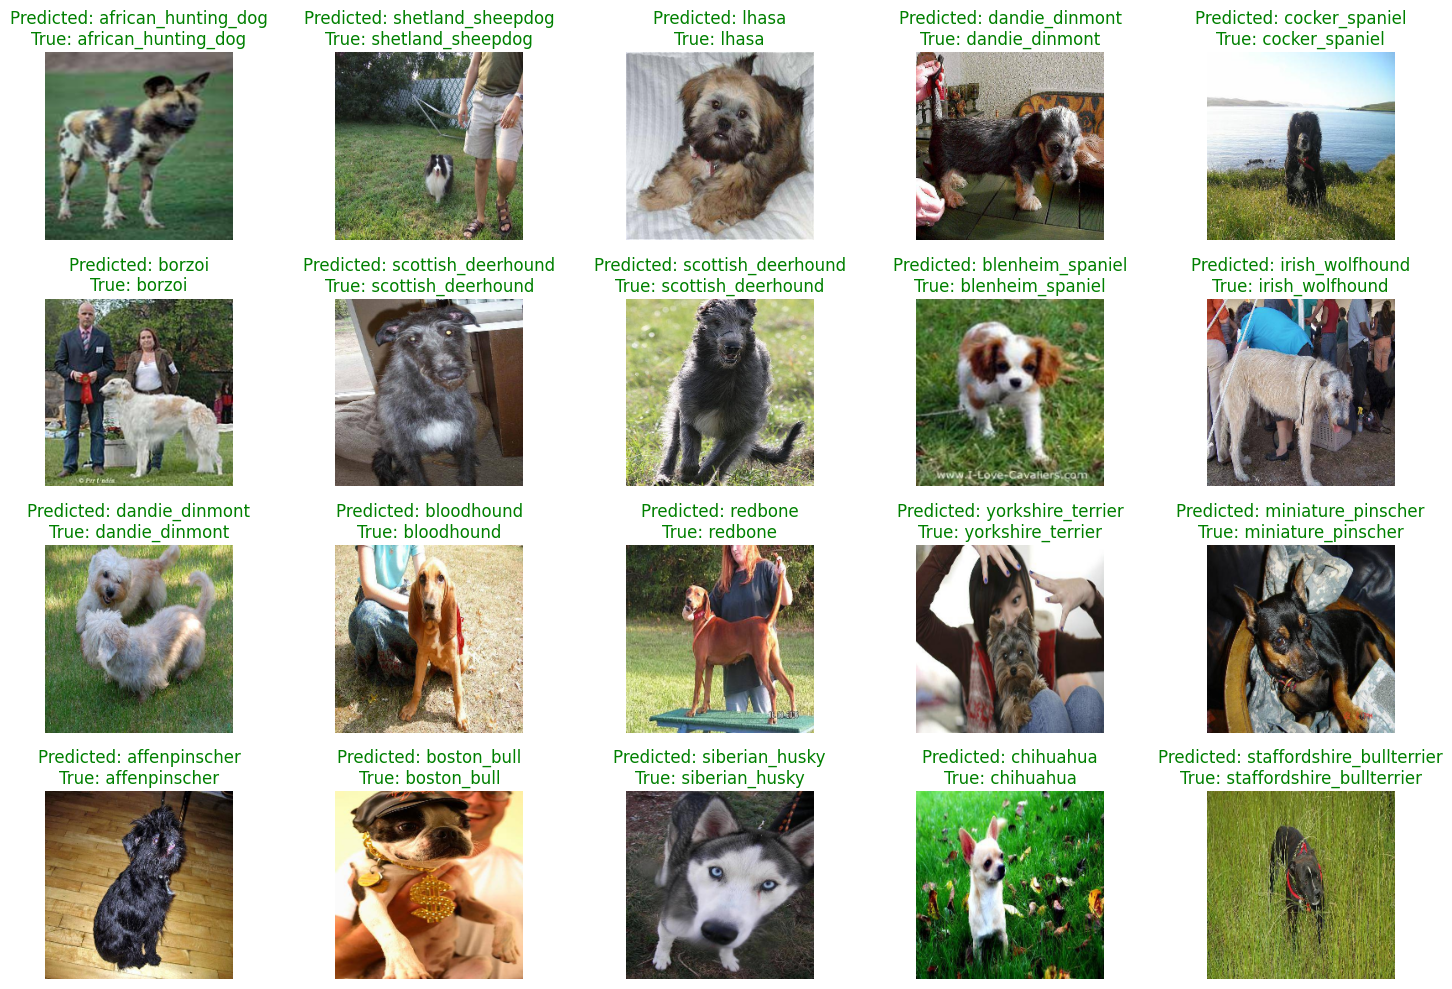

In [22]:
images_random_20 = [resized_images[i] for i in random_indices]
predicted_labels_random_20 = all_predicted_labels[random_indices]
true_labels_random_20 = true_labels[random_indices]


predicted_labels_names = label_encoder.inverse_transform(predicted_labels_random_20)
true_labels_names = label_encoder.inverse_transform(true_labels_random_20)

plot_images(images_random_20, predicted_labels_names, true_labels_names, class_names)